# Assignment-1 Linear Programming
  The objective of this assignment is to show the applications of linear programming in real life problems. You will be asked to solve problems from classical physics to puzzles. 

## Instructions 
  - For each question you need to write the formulation in markdown and solve the problem using `cvxpy`. 
  - Ensure that this notebook runs without errors when the cells are run in sequence.
  - Plagarism will not be tolerated.
  - Use only `python3` to run your code.
  - If you are facing issues running the notebook on your local system. Use google collab to run the notebook online. To run the notebook online, go to [google collab](!https://colab.research.google.com/notebooks/intro.ipynb). Go to `File  -> Upload Notebook` and import the notebook file 

## Submission  
- Rename the notebook to `<roll_number>.ipynb` and submit **ONLY** the notebook file on moodle.

## Problems 
1. Sudoku 
2. Best Polyhedron 
3. Largest Ball
4. Illumination Problem
5. Jigsaw Puzzle 

In [1]:
# Compatibility imports
from __future__ import print_function, division

# Imports
import os 
import sys
import random

import numpy as np 
import cvxpy as cp 

import matplotlib.pyplot as plt 
import matplotlib.path as mplPath

# Modules specific to problems 
from sklearn.datasets import make_circles # For problem 2 (Best Polyhedron) 
from scipy.spatial import ConvexHull # For problem 3 (Largest Ball in Polyhedron)
from scipy.linalg import null_space # For problem 4 (Illumination)
import matplotlib.cbook as cbook # For problem 5 (Jigsaw)
from skimage.transform import resize # For problem 5 (Jigsaw)
import copy # for question 5
%matplotlib inline

## Question-1 Sudoku 
- In this problem you will develop a mixed integer programming algorithm, based upon branch and bound, to solve Sudoku puzzles as described in class.
- In particular, you need to implement the class SudokuSolver 

The function takes as input a Sudoku puzzle as a 9x9 “list of lists” of integers, i.e.,


    puzzle = [[4, 8, 0, 3, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 7, 1],
              [0, 2, 0, 0, 0, 0, 0, 0, 0],
              [7, 0, 5, 0, 0, 0, 0, 6, 0],
              [0, 0, 0, 2, 0, 0, 8, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 7, 6, 0, 0, 0],
              [3, 0, 0, 0, 0, 0, 4, 0, 0],
              [0, 0, 0, 0, 5, 0, 0, 0, 0]]

where zeros represent missing entries that must be assigned by your algorithm, and all other integers represent a known assignment. 

- The class SudokuSolver inherits the Sudoku class. You need to make changes **only** to the SudokuSolver class. Write function `plot` to plot the unsolved and solved puzzle. Write function `solve` to create our own solver, the function can get the unsolved puzzle as the input as should return a 9x9 numpy array (solved puzzle), where solved puzzle contains the input puzzle with all the zeros assigned to their correct values. For instance, for the above puzzle
this would be

    
    solved_puzzle = [[4, 8, 7, 3, 1, 2, 6, 9, 5],
                     [5, 9, 3, 6, 8, 4, 2, 7, 1],
                     [1, 2, 6, 5, 9, 7, 3, 8, 4],
                     [7, 3, 5, 8, 4, 9, 1, 6, 2],
                     [9, 1, 4, 2, 6, 5, 8, 3, 7],
                     [2, 6, 8, 7, 3, 1, 5, 4, 9],
                     [8, 5, 1, 4, 7, 6, 9, 2, 3],
                     [3, 7, 9, 1, 2, 8, 4, 5, 6],
                     [6, 4, 2, 9, 5, 3, 7, 1, 8]]
    

- You should write code to solve this problem using cvxpy.

**Write the code in SudokuSolver class only**. 

In [2]:
# Class Sudoku will generate new sudoku problems for you to solve. You cannot change this code. Complete the formulation and the solver below 
class Sudoku():
  def __init__(self):
    super(Sudoku,self).__init__()
    self.puzzle = None # Unsolved sudoku 
    self.solution = None # Store the solution here
    pass

  def construct_solution(self):
    """
      This function created a 9x9 solved sudoku example. 
      It can be used as a reference to see the performance of your solver.
    """
    while True: # until a solved sudoku puzzle if created
      puzzle = np.zeros((9,9))
      rows    = [set(range(1,10)) for i in range(9)] #   set of available
      columns = [set(range(1,10)) for i in range(9)] #   numbers for each
      squares = [set(range(1,10)) for i in range(9)] #   row, column and square

      try:
        for i in range(9): # for each roe
          for j in range(9): # for each column

            # Randomly choose a possible number for the location
            choices = rows[i].intersection(columns[j]).intersection(squares[(i//3)*3 + j//3])
            choice  = random.choice(list(choices))

            puzzle[i,j] = choice	# update the puzzle
            
            # Remove from the choice from row,column, square
            rows[i].discard(choice) 
            columns[j].discard(choice)
            squares[(i//3)*3 + j//3].discard(choice)

        # success! every cell is filled.
        return puzzle

      except IndexError:
        # if there is an IndexError, we have worked ourselves in a corner (we just start over)
        continue 
      
  def construct_problem(self,solution,n=28):
    """
      Construct the puzzle by removing a cell if it is possible to deduce a cell's value from the remaining cells 
      @param: n => minimum number of unplucked/remaining cells  
    """

    def canBeDeduced(puz, i, j, c): # check if the cell can be deduced from the remaining cells 
      v = puz[c//9,c%9]
      if puz[i,j] == v: return True
      if puz[i,j] in range(1,10): return False
        
      for m in range(9): # test row, col, square
        # if not the cell itself, and the mth cell of the group contains the value v, then "no"
        if not (m==c//9 and j==c%9) and puz[m,j] == v: return False
        if not (i==c//9 and m==c%9) and puz[i,m] == v: return False
        if not ((i//3)*3 + m//3==c//9 and (j//3)*3 + m%3==c%9) and puz[(i//3)*3 + m//3,(j//3)*3 + m%3] == v:
          return False

      return True


    cells = set(range(81))	
    cellsLeft = set(range(81))

    while len(cells) > n and len(cellsLeft): # Cells in the problem > n and cells left to be plucked > 0	
      cell = random.choice(list(cellsLeft)) # choose a random cell
      cellsLeft.discard(cell)

      # record whether another cell in these groups could also take
      # on the value we are trying to pluck
      row = col = square = False  

      for i in range(9): # For all numbers
        if i != cell/9: # can be deduced from the row
          if canBeDeduced(solution, i, cell%9, cell): row = True
        if i != cell%9: # can be deduced from the col
          if canBeDeduced(solution, cell//9, i, cell): col = True
        if not (((cell//9)//3)*3 + i//3 == cell//9 and ((cell//9)%3)*3 + i%3 == cell%9): # can be deduced from the square
          if canBeDeduced(solution, ((cell//9)//3)*3 + i//3, ((cell//9)%3)*3 + i%3, cell): square = True

      if row and col and square:
        continue # could not pluck this cell, try again.
      else:
        # this is a pluckable cell!
        solution[cell//9][cell%9] = 0 # 0 denotes a blank cell
        cells.discard(cell) # remove from the set of visible cells (pluck it)
        # we don't need to reset "cellsleft" because if a cell was not pluckable
        # earlier, then it will still not be pluckable now (with less information
        # on the board).

    return solution    

### Problem Formulation
We assume that each cell in the sudoku matrix(9x9) is a vector with nine values. The vector elements can take values zero or one such that exactly one element will have value one and the rest will be zero. The nine elements indicate the possible values the cell can take and the index at which it is equal to 1 is the value of the cell.

Now what we have is a (9x9x9) 3D matrix in which the sum along all rows, columns and along the depth should be equal to one.
(Note: By slice I=we refer to a 2d matrix along the depth)
This translates as:
- The sum along rows in each slice should be equal to (ensures the a particular number comes only once in each row)
- The sum along columns in each slice should be equal to (ensures the a particular number comes only once in each column)
- The sum along depth in each cell should equal to 1( so that each cell has a unique value)
- We ensure at all places the values in the 3D matrix are between zero and 1.
- We also ensure known values are given value 1 at the appropriate locations.

### Problem:
$Given \space grid \space G \space with \space 0's \space and \space numbers \space in \space range \space 1-9 \space , \space solve \space Sudoku \space puzzle.$

$G(i, j) = 0 \space or \space G(i, j) \in \{1, 2, ..., 9\}$

### Objective: 

$Minimize \space \sum_{i=1}^{9} \sum_{j=1}^{9} \sum_{k=1}^{9} X_{i, j}^{(k)}$ 

$where X\space is\space a\space 3D \space grid \space and \space i, \space j \space span \space rows \space and \space columns \space of \space the \space grid, \space and \space k \space iterates \space over \space every \space slice$

### Constraints:

$\sum_{k=1}^9 X_{i, j}^{(k)} = 1\space \space \space \space \forall  i,j$

$\sum_{i=1}^9 X_{i, j}^{(k)} = 1\space \space \space \space \forall  j,k$

$\sum_{j=1}^9 X_{i, j}^{(k)} = 1\space \space \space \space \forall  i,k$

$\sum_{i=3a+1}^{3a+3} \sum_{j=3b+1}^{3b+3} X_{i, j}^{(k)} = 1\space \space \space \space \forall \space k  \space \space \forall \space a, b \in \{0, 1, 2\}$

$X_{i, j}^{(k)} = 1 \space \space \space \forall \space G(i, j) = k \space, where \space k = \{1, 2, ..., 9\} $

$X_{i, j}^{(k)} \in \{0, 1\}$

In [3]:
# Create your sudoku puzzle solver here
class SudokuSolver(Sudoku):
    
    def __init__(self):
        super(SudokuSolver,self).__init__()
        self.solution = self.construct_solution() # Store the solution here
        self.puzzle = self.construct_problem(self.solution.copy(),n=28) # Unsolved sudoku 
        self.variables = [] 
        self.constraints = []
    def plot(self):
        print("Puzzle")
        print(self.puzzle.astype(int))

        """
          Write code here for plotting your solution
        """
        print("My Solution")
        sol = np.zeros((9,9)).astype(int)
        mat = np.array([np.round(v.value).astype(int) for v in self.variables])
        for i in range(9):
            for j in range(9):
                sol[i,j] = np.where(mat[:,i,j]==1)[0][0]+1
        print(sol)
        print("Original Solution")
        print(self.solution.astype(int))   

    def solve(self):
        """
        Write your code here.
        The function should return the solved sudoku puzzle 
        """
        # Define the variables
        for i in range(9):
            self.variables.append(cp.Variable((9,9),boolean=True))
            
        # Put in the constraints    
        for i in range(9):
            for j in range(9):
                # For the fixed values
                if self.puzzle[i,j]>0:
                    self.constraints.append(self.variables[self.puzzle[i,j].astype(int)-1][i,j] == 1) 
                # all rows sum to 1
                self.constraints.append(cp.sum(self.variables[i][j,:])==1)
                # all columns sum to 1
                self.constraints.append(cp.sum(self.variables[i][:,j])==1)  
                # every element can take only one value
                self.constraints.append(self.variables[0][i,j]+\
                                   self.variables[1][i,j]+\
                                  self.variables[2][i,j]+\
                                  self.variables[3][i,j]+\
                                  self.variables[4][i,j]+\
                                  self.variables[5][i,j]+\
                                  self.variables[6][i,j]+\
                                  self.variables[7][i,j]+\
                                  self.variables[8][i,j]==1)
            # every block sums to 1
            for p in [0,3,6]:
                for q in [0,3,6]:            
                    self.constraints.append(cp.sum(self.variables[i][p:p+3,q:q+3])==1)                         
        # the objective as a minimization problem
        objective = cp.Minimize(cp.sum(self.variables[0])+\
                               cp.sum(self.variables[1])+\
                               cp.sum(self.variables[2])+\
                               cp.sum(self.variables[3])+\
                               cp.sum(self.variables[4])+\
                               cp.sum(self.variables[5])+\
                               cp.sum(self.variables[6])+\
                               cp.sum(self.variables[7])+\
                               cp.sum(self.variables[8]))
        problem = cp.Problem(objective,self.constraints)
        # using branch and bound to solve the problem
        problem.solve(solver=cp.ECOS_BB)                   

solver = SudokuSolver()
solver.solve()
solver.plot()

Puzzle
[[5 0 4 9 8 0 2 0 3]
 [0 0 0 6 0 0 0 7 5]
 [0 6 0 0 4 0 8 9 0]
 [0 0 7 0 9 0 1 4 0]
 [8 2 0 7 6 0 5 0 0]
 [3 0 9 5 1 0 7 8 0]
 [0 7 0 4 0 3 6 0 0]
 [0 8 6 1 5 0 0 2 0]
 [1 0 2 0 7 0 0 0 4]]
My Solution
[[5 1 4 9 8 7 2 6 3]
 [2 9 8 6 3 1 4 7 5]
 [7 6 3 2 4 5 8 9 1]
 [6 5 7 3 9 8 1 4 2]
 [8 2 1 7 6 4 5 3 9]
 [3 4 9 5 1 2 7 8 6]
 [9 7 5 4 2 3 6 1 8]
 [4 8 6 1 5 9 3 2 7]
 [1 3 2 8 7 6 9 5 4]]
Original Solution
[[5 1 4 9 8 7 2 6 3]
 [2 9 8 6 3 1 4 7 5]
 [7 6 3 2 4 5 8 9 1]
 [6 5 7 3 9 8 1 4 2]
 [8 2 1 7 6 4 5 3 9]
 [3 4 9 5 1 2 7 8 6]
 [9 7 5 4 2 3 6 1 8]
 [4 8 6 1 5 9 3 2 7]
 [1 3 2 8 7 6 9 5 4]]


## Question-2 Polyhedron

Explain how you would solve the following problem using linear programming. You
are given two sets of points in R<sub>n</sub>:

$$S1 = \{ x_1, . . . , x_N \}, \space S2 = \{y_1, . . . , y_M\}.$$
You are asked to find a polyhedron
$$P = \{x | \space a_i^T x ≤ b_i, i = 1, . . . , m\}$$
that contains the points in S1 in its interior, and does not contain any of the points in S2:
$$S1 ⊆ \{x | \space a_i^T x < b_i, i = 1, . . . , m\}$$
$$ S2 ⊆ \{x |\space  a_i^T x > b_i \space for \space \space at \space \space least\space\space  one \space i \} = R_n - P.$$

An example is shown in the figure, with the points in S1 shown as open circles and the points in S2 as filled circles. You can assume that the two sets are separable in the way described. 

![alt text](https://drive.google.com/uc?export=view&id=19N_kj6cOXZmaKvlMExOScoqRTPegKODM)

- Your solution method should return a_i and b_i, i = 1, . . . , m, given the sets S1 and S2. The number of inequalities
m is not specified, but it should not exceed 20, i.e your polyhedron should not have more than 20 faces. 

- You are allowed to solve one or more
LPs or LP feasibility problems. The method should be efficient, i.e., the dimensions of the
LPs you solve should not be exponential as a function of N and M.

- You can calculate the quality of your solution by dividing the number of points in S1 your polyhedron is leaving out (points lying outside the polyhedron) by the total number of points in the set S1 (= N). The lower the value, the more efficient your solution will be. Use this metric to choose the most efficient solution out of all the possible solutions.

- The class PolyhedronSolver inherits the Polyhedron class. You need to make changes **only** to the PolyhedronSolver class. Write function `plot` to plot the points and the polyhedron (Look at question-3 on how to plot a polyhedron). Write function `solve` to create our own solver, the function can get the S1 & S2 as the input as should return a numpy array of size Dx2, where the D is the number the vertices of the polyhedron. 

In [4]:
class Polyhedron():
  def __init__(self):
    super(Polyhedron,self).__init__()
    data, labels = make_circles(n_samples=1000, noise=0.15,factor=0.3) # This will create our data
    self.S1 = data[labels==0] # Points outside the polyhedron
    self.S2 = data[labels==1] # Points intside the polyhedron

### Problem Formulation
We need to find a polyhedron with max 20 faces which can enclose as many points of S2 as possible whereas leaving out all the points belonging to set S2.

Analysis of the data distribution leads to circular spread of data points, so we try to fit a circle around the point of set S2.

Knowing about the circular distribution, we can get the center of the circle as the mean of the points belonging to S2, so only the radius needs to be calculated.

### Objective and Constraints
$Max \;\; \sum{y} \\ 
s.t. \  |p_i - c|_2 >= r \;\; \forall \;\; p_i \; \epsilon \; S_1 \\
y = r - |q_i - c|_2 \;\; \forall \;\; q_i \; \epsilon \; S_2 $

where c is the centre of the circle and r is the radius.

optimal
(20, 2)


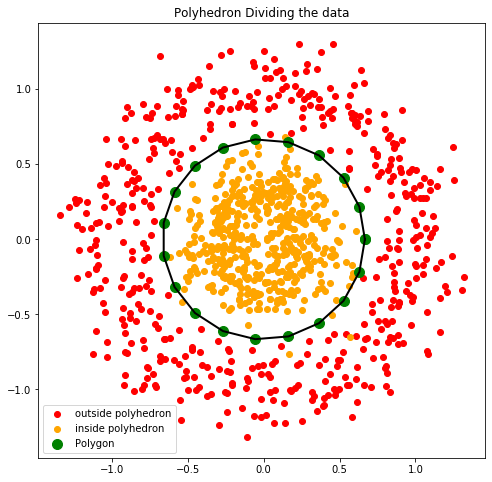

In [5]:
class PolyhedronSolver(Polyhedron):
  def __init__(self):
    super(PolyhedronSolver,self).__init__()
    self.polygon = []
    self.n1 = self.S1.shape[0]
    self.n2 = self.S2.shape[0]
    self.constraints = []
    

  def plot(self):
    fig = plt.figure(figsize=(8,8)) # Create 8x8 inches figure  
    ax = fig.add_subplot(111) # Create a graph inside the figure
    ax.scatter(self.S1[:,0],self.S1[:,1],c="red",label="outside polyhedron") # Plot S1
    ax.scatter(self.S2[:,0],self.S2[:,1],c="orange",label="inside polyhedron") # PlotS2

    """
      Write code here for plotting your polyhedron
    """
    ax.plot(self.polygon[:,0],self.polygon[:,1],linewidth=2,c="black") # Plot the points
    ax.plot([self.polygon[0,0],self.polygon[-1,0]],[self.polygon[0,1],self.polygon[-1,1]],linewidth=2,c="black") # Plot the edges
    ax.scatter(self.polygon[:,0],self.polygon[:,1],s=100,c="green",label="Polygon")


    ax.set_title("Polyhedron Dividing the data")
    plt.legend()
    plt.show()
  def solve(self):
    """
      Write your code here. 
    """
    radius = cp.Variable()
    dist = cp.Variable(self.n2)
    
    self.constraints.append(radius >= 0)
    self.constraints.append(np.sqrt(self.S1[:, 0]**2 + self.S1[:, 1]**2) >= radius)
    self.constraints.append(dist == radius - np.sqrt(self.S2[:, 0]**2 + self.S2[:, 1]**2))
    
    objective = cp.Maximize(cp.sum(dist))
    problem = cp.Problem(objective, self.constraints)
    result = problem.solve()
    print(problem.status)
    
    radius = radius.value
    angle = np.linspace(0, 2*np.pi, 20)
    
    vertex = np.zeros((20, 2))
    vertex[:, 0] = radius * np.cos(angle)
    vertex[:, 1] = radius * np.sin(angle)

    self.polygon = vertex
    
    print(self.polygon.shape)
    
    bbPath = mplPath.Path(vertex)
    count = bbPath.contains_points(self.S2)
    return count
    
solver = PolyhedronSolver()
count = solver.solve()
solver.plot()


## Question-3  Largest Ball in a polyhedron

Find the largest ball 
$$ B(x_c, R) = \{ x :  ||x − x_c|| ≤ R \}$$
enclosed in a given polyhedron
$$ P = \{ x | a_i^T x ≤ b_i, i = 1, . . . , m\} $$

- The problem variables are the center x<sub>c</sub> ∈ R<sub>n</sub> and the radius R of the ball.

- The class CircleSolver inherits the CircleSolver class. You need to make changes only to the CircleSolver class. Write function `plot` to plot the polyhedron and the circle. Write function `solve` to create our own solver, the function can get the polyhedron as the input as should return a tuple (center,radius) where center is 1x2 numpy array containing the center of the circle, and radius is a scalar value containing the largest radius of the possible. 

In [6]:
class CircleInPolygon():
  def __init__(self):
     super(CircleInPolygon,self).__init__()
     self.polygon = np.random.random((10,2))
     self.polygon = self.polygon[ConvexHull(self.polygon).vertices,:] # A polygon is stored here

### Problem Formulation
Let us have a polyhedron, defined by the inequalities of the form:

P = $ x \ | \ a_i^T x \leq b_i, \ i=1,\ldots,m  $

We need to find the largest circle that can fit inside this polyhedron. We model the circle using its centre x and radius R. We put contraints such that the centre in inside the polyhedron and radius is maximized.

We find the equations of all lines from the 2 point formula and check for the inequality sign by checking with the mean of all points, by using the fact that the mean of all vertices of a convex polyhedron lies inside the polyhedron.

### Objective and Constraints
$\max \ r \\ s.t. \  a_i^Tx + r||a_i||_2 \leq b_i \quad \forall i \in [m]$

where x is the centre of the circle and r is the radius.

Centre:  (0.4816193393294762, 0.5616546517039984) Radius:  0.2602161349106376


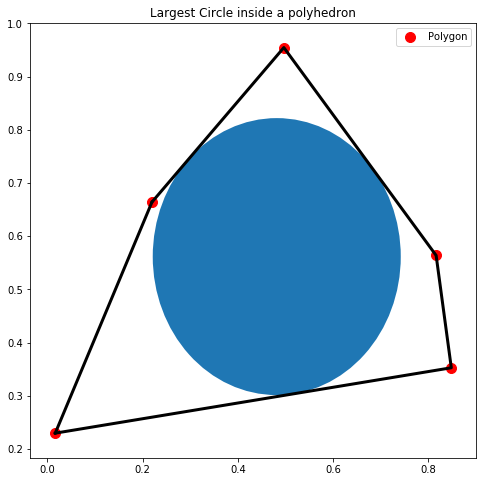

In [7]:
# Create your circle puzzle solver here
class CircleSolver(CircleInPolygon):
  def __init__(self):
    super(CircleSolver,self).__init__()
    self.mean = np.mean(self.polygon,axis=0)    
    self.centre = cp.Variable(2)
    self.R = cp.Variable()
    
  def plot(self):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.plot(self.polygon[:,0],self.polygon[:,1],linewidth=3,c="black") # Plot the points
    ax.plot([self.polygon[0,0],self.polygon[-1,0]],[self.polygon[0,1],self.polygon[-1,1]],linewidth=3,c="black") # Plot the edges
    ax.scatter(self.polygon[:,0],self.polygon[:,1],s=100,c="red",label="Polygon") # Plot the edge connecting last and the first point

    """
     Add code to plot the circle
    """
    ax.set_title("Largest Circle inside a polyhedron")
    plt.scatter(self.mean[0],self.mean[1])
    circle = plt.Circle(tuple(self.centre.value),self.R.value)
    ax.add_artist(circle)
    plt.legend()
    plt.show()


  def solve(self):

    constraints = []
    
    n = self.polygon.shape[0]
    
    for i in range(n):
        x1 = self.polygon[i][0]
        y1 = self.polygon[i][1]
        x2= self.polygon[(i+1)%n][0]
        y2= self.polygon[(i+1)%n][1]
        a = np.array([y2-y1,-x2+x1])
        b = (y2-y1)*x1-(x2-x1)*y1

        if a@self.mean <= b:
            constraints.append(a@self.centre + self.R*cp.norm(a) <= b)
        else:
            constraints.append(a@self.centre + self.R*cp.norm(a) >= b)
                
    objective = cp.Maximize(self.R)
    problem = cp.Problem(objective,constraints)
    problem.solve()  
    return (self.centre.value,self.R.value)
    
    

solver = CircleSolver()
c,r = solver.solve()
print("Centre: ",tuple(c),"Radius: ",r)
solver.plot()

## Question-4 Illumination Problem 


We consider an illumination system of m lamps, at positions l<sub>1</sub>, . . . , l<sub>m</sub> ∈ R<sup>2</sup>, illuminating n flat patches. 
The patches are line segments; the ith patch is given by $$[v_i, v_i+1]$$ where v<sub>1</sub>, . . . , v<sub>n+1</sub> ∈ R<sup>2</sup>. The variables in the problem are the lamp powers p<sub>1</sub>, . . . , p<sub>m</sub>, which can vary between 0 and 1.
The illumination at (the midpoint of) patch i is denoted I<sub>i</sub>. We will use a simple model for the illumination:


   $$Ii = \sum_{j=1}^m a_{ij}p_{j} $$
   $$ a_{ij} = r_{ij} ^{−2} ( max(cos θ_{ij},0) )$$
where r<sub>ij</sub> denotes the distance between lamp j and the midpoint of patch i, and θ<sub>ij</sub> denotes the angle between the upward normal of patch i and the vector from the midpoint of patch i to lamp j. 

![alt text](https://drive.google.com/uc?id=1ZyHm9hmKKZRvLryNkiixTEMTCxZts0qH)

This model takes into account “self-shading” (i.e., the fact that a patch is illuminated only by lamps in the halfspace it faces) but not shading of one patch caused by another. Of course we could use a more complex illumination model, including shading and even reflections. This just changes the matrix relating the lamp powers to the patch illumination levels.

The problem is to determine lamp powers that make the illumination levels close to a given desired illumination level Ides, subject to the power limits 0 ≤ p<sub>i</sub> ≤ 1. Suppose we use the maximum deviation

####   $$ φ(p) = max_{k=1,...,n} |I_{k} − I_{des}| $$
as a measure for the deviation from the desired illumination level. Formulate the illumination problem using this criterion as a linear programming problem.

Create the data using the $Illumination$ class and solve the problem using IlluminationSolver class. 
The elements of A are the coefficients a<sub>ij</sub> in the above equation. 

Compute a feasible p using this first method, and calculate φ(p)



In [8]:
class Illumination():
  def __init__(self):
    super(Illumination,self).__init__()

    # Lamp position
    self.Lamps = np.array([[0.1 ,0.3, 0.4, 0.6 ,0.8 ,0.9 ,0.95],[1.0, 1.1, 0.6 ,0.9, 0.9 ,1.2, 1.00]])
    self.m = self.Lamps.shape[1]    # number of lamps

    # begin and endpoints of patches  
    self.patches = [np.arange(0,1,1/12),np.array([0 ,0.1 ,0.2, 0.2, 0.1, 0.2 ,0.3 ,0.2 ,0 ,  0 ,  0.2, 0.1])]
    self.patches = np.array(self.patches)
    self.n = self.patches.shape[1] -1  # number of patches

    # desired illumination
    Ides = 2;

    # construct A
    self.dpatches = self.patches[:,1:] - self.patches[:,:-1];  # tangent to patches
    self.patches_mid = self.patches[:,1:] - 0.5*self.dpatches;         # midpoint of patches
    A = np.zeros((self.n,self.m));
    for i in range(self.n):
      for j in range(self.m):
        dVI = self.Lamps[:,j]-self.patches_mid[:,i] # Find the distance between each lamp and patch 
        rij = np.linalg.norm(dVI,ord=2) # Find the radius/distance between lamp and the midpoint of the patch 
        normal = null_space(self.dpatches[:,i].reshape(1,2)) # Find the normal

        if normal[1] < 0: # we want an upward pointing normal  
          normal = -1*normal
        A[i,j] = dVI.dot(normal)/(np.linalg.norm(dVI,ord=2)*np.linalg.norm(normal,ord=2))/(rij**2); # Find A[i,j] as defined above
        if A[i,j] < 0: 
          A[i,j] = 0

    self.A = A

### Problem Formulation
Let A matrix be defined as:

$$ a_{ij} = r_{ij} ^{−2} ( max(cos θ_{ij},0) )$$
where r<sub>ij</sub> denotes the distance between lamp j and the midpoint of patch i, and θ<sub>ij</sub> denotes the angle between the upward normal of patch i and the vector from the midpoint of patch i to lamp j. 

Let vector p denote the m lamp powers p1, . . . , pm, which can vary between 0 and 1.

Now $ Ap = I $

where I is the vector of final intensity values given current p and configuration matrix A.
We have to minimize:

$$ φ(p) = max_{k=1,...,n} |I_{k} − I_{des}| $$

where $I_{des}$ is the vector of desired intensity values.

This is the same as minimizing the $L_{\infty}$ norm of $|I_{k} − I_{des}|$

Here $I_{k}$ can be written as Ap.

### Objective and constraints
$$ Minimize \space {\lvert\lvert Ap − I_{des}\lvert\lvert}_{\infty}$$

$$ subject \space to : \space 0 <= p_{i} <= 1 \forall \space i \space in \space 1 \space to \space m $$ 

1.0910372833318458
[1.00000000e+00 6.63700612e-01 1.93214121e-12 7.79154700e-11
 6.05993369e-10 2.65217469e-01 1.00000000e+00]
[0.90896272 1.27413748 3.09103728 2.08961927 1.70891967 2.20309763
 2.05699846 0.90896272 2.17125121 1.40098029 1.20749789]


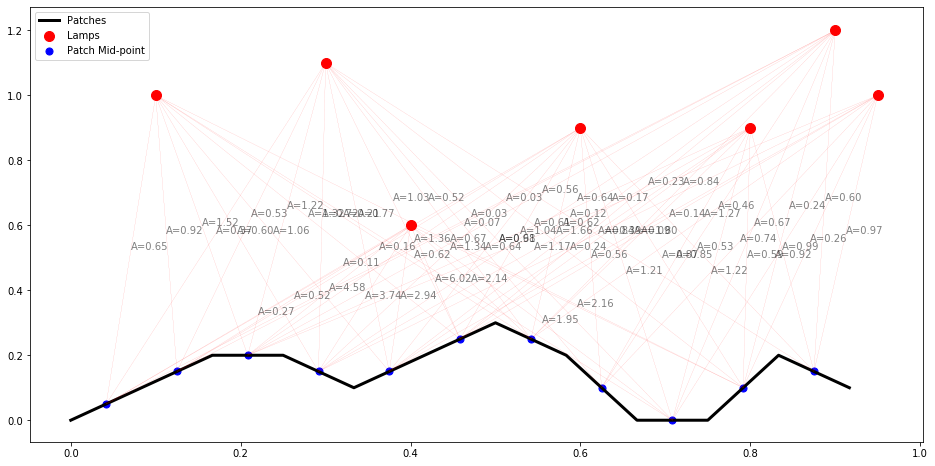

In [9]:
# Create your illumination solver here
class IlluminationSolver(Illumination):
  def __init__(self):
    super(IlluminationSolver,self).__init__()

  def plot(self):
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
     
    ax.scatter(self.Lamps[0,:],self.Lamps[1,:],s=100,c="red",label="Lamps") # Lamps
    ax.scatter(self.patches_mid[0,:],self.patches_mid[1,:],s=50,c="blue",label="Patch Mid-point") # Lamps
    ax.plot(self.patches[0,:],self.patches[1,:],linewidth=3,c="black",label="Patches") # Patches

    # Normal joining lamps and patchs 
    for i in range(self.n):
      for j in range(self.m):
        if self.A[i,j] > 0:
          ax.plot([self.Lamps[0,j], self.patches_mid[0,i]],[self.Lamps[1,j], self.patches_mid[1,i]],'r--',linewidth=0.1,alpha=1)
          ax.text((self.Lamps[0,j]+self.patches_mid[0,i])/2,(self.Lamps[1,j] + self.patches_mid[1,i])/2,"A={0:.2f}".format(self.A[i,j]),alpha=0.5)

    plt.legend()
    plt.show()
  
  def solve(self):
    """
      Write your solver here
    """
    p = cp.Variable(self.m)
    Ides = 2
    objective = cp.Minimize(cp.max(cp.norm(self.A @ p - Ides,"inf")))
    constraints = [p>=0,p<=1]
    problem = cp.Problem(objective,constraints)
    print(problem.solve())  
    print(p.value)
    print(self.A @ p.value)
    

solver = IlluminationSolver()
solver.solve()
solver.plot()


## Question-5 Jigsaw 

Solving jigsaw puzzles computationally remains a relevant and intriguing problem noted for its applications to real-world problems. 

In this problem, you'll implement a solver that solves jigsaw puzzles using linear programming. 

The current problem requires you to only solve Type I problems (i.e. problems where the orientation of the pieces is known).

You may refer to this paper [Solving Jigsaw Puzzles with Linear Programming](https://arxiv.org/abs/1511.04472) for implementation details. 

![alt text](https://drive.google.com/uc?id=19MyWwH6XV4jz244E5yBJAH0baZAXddVx)

- Jigsaw class will take an image as input and will create a random jigsaw puzzle. Function patches2image will reconstruct the image back from the patches

- The class JigsawSolver inherits the Jigsaw class. You need to make changes only to the JigsawSolver class. Write function `solve` to create our own solver, the function can get a numpy array of shape RxCxHxWx3 as input, where R & C are the number of  rows and cols in the jigsaw puzzle respectively and HxW is the height and width of each peice. The output of the function should be a numpy array of shape RxCxHxWx3 which would be the solution.  

In [10]:
class Jigsaw():
  def __init__(self,path=None):
    super(Jigsaw,self).__init__()
    """
      Initialize your Jigsaw puzzle, you can provide path to an image or we will load the default image
    """
    if path is None:  # Load default image  
      with cbook.get_sample_data('grace_hopper.png') as image_file:
        self.image = plt.imread(image_file)
    else:
      self.image = plt.imread(path)  # Load image of your choice

    self.original_size = self.image.shape[0:2] #Store the original size of the image
    self.new_size = (500,500) # Store new image size, 500x500
    self.rows = 5 # number of rows in jigsaw puzzle
    self.cols = 5 # number of cols in jigsaw puzzle

    # RxCxHxWx3 numpy array storing the jigsaw puzzle
    self.jigsaw = self.create_jigsaw_puzzle(self.image,self.new_size,self.rows,self.cols)

  
  def image2patches(self,image,new_size,rows,cols):
    """
      This function converts an image to patches for jigsaw puzzle
      @param: image -> input image
      @param: new_size -> shape to which image will be resized
      @param: rows -> number of rows in the jigsaw puzzle
      @param: rows -> number of cols in the jigsaw puzzle

      @returns: patches -> RxCxHxWx3 numpy array storing the jigsaw puzzle's patches
    """

    image = resize(image,self.new_size) # resize the original image 
    patches = np.zeros((self.rows,self.cols,self.new_size[0]//self.rows,self.new_size[1]//self.cols,3)) # store the jigsaw puzzle here
    for i in range(self.rows): # for every row of jigsaw
      for j in range(self.cols): # for every col of jigsaw
        patches[i,j,:,:,:] = self.image[i*self.new_size[0]//self.rows:(i+1)*self.new_size[0]//self.rows,j*self.new_size[0]//self.cols:(j+1)*self.new_size[0]//self.cols,:]
    return patches 

  def patches2image(self,patches,original_size):
    """
      This function recreates images from patches
      @param: patches -> RxCxHxWx3 numpy array storing the jigsaw puzzle's patches
      @param: orignal_size -> shape to which image will be resized

      @returns: image -> output image 
    """
    R,C,H,W,_ = patches.shape
    image = np.zeros((R*H,C*W,3))
    for i in range(R):
      for j in range(C):
        image[i*H:(i+1)*H,j*W:(j+1)*W,:] = patches[i,j,:,:,:] 
    
    image = resize(image,original_size) 
    return image 

  def create_jigsaw_puzzle(self,image,new_size,rows,cols):
    patches = self.image2patches(image,new_size,rows,cols)
    R,C,H,W,_ = patches.shape
    patches = patches.reshape((-1,H,W,3))
    patches = patches[np.random.permutation(R*C),...].reshape((R,C,H,W,3))
    return patches

### Problem Formulation
As explained in the paper we can formulate the problem as follows:

### Objective and Constraints
$$ Minimize \space C(x) = \sum_{(i,j,o) \in A} w_{ijo}h_{ijo}^{(x)}$$

$$ subject \space to $$

$$   h_{ijo}^{(x)} \ge x_{i}-x_{j}- \delta_{o}^{x} \space \forall \space (i,j,o) \space \in \space A $$

$$   h_{ijo}^{(x)} \ge x_{j}-x_{i}+\delta_{o}^{x} \space \forall \space (i,j,o) \space \in \space A $$

$\space$

$$ Minimize \space C(y) = \sum_{(i,j,o) \in A} w_{ijo}h_{ijo}^{(y)}$$

$$ subject \space to $$

$$   h_{ijo}^{(y)} \ge y_{i}-y_{j}- \delta_{o}^{y} \space \forall \space (i,j,o) \space \in \space A $$

$$   h_{ijo}^{(y)} \ge y_{j}-y_{i}+\delta_{o}^{y} \space \forall \space (i,j,o) \space \in \space A $$

$\space$

$$ A = \{ (i,j,o) \in U : j = \underset{j:(i,j,o) \in U}{ \operatorname{argmin}}D_{ijo} \} $$

$$ w_{ijo} = \frac{\min( \min_{k \neq i}D_{kjo}, \min_{k \neq j} D_{iko} )}{D_{ijo}} $$

$$ \delta_{o}^{x}=   \left\{
\begin{array}{ll}
      0 & o = 1 \\
      -1 & o = 2 \\
      0 & o=3\\
      1 & o= 4
      \end{array} 
\right.  $$

$$ \delta_{o}^{y}=   \left\{
\begin{array}{ll}
      0 & o = 1 \\
      -1 & o = 2 \\
      0 & o=3\\
      1 & o= 4
      \end{array} 
\right.  $$

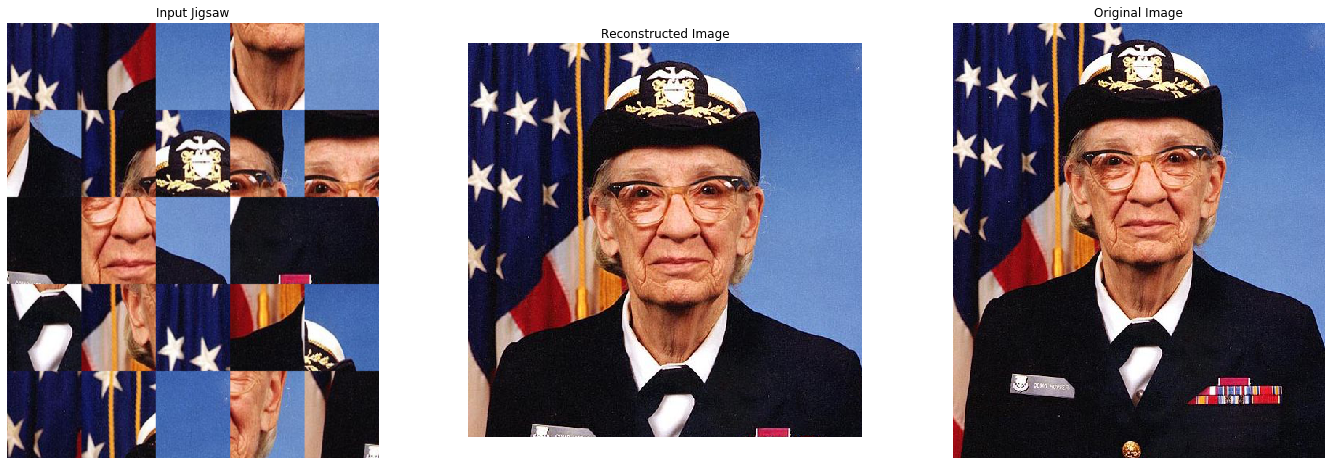

In [11]:
class JigsawSolver(Jigsaw):
  def __init__(self, *args, **kwargs):
    super(JigsawSolver, self).__init__()
    self.block_size = self.jigsaw.shape[2]
    self.n = self.jigsaw.shape[0] * self.jigsaw.shape[1]
    self.D = []
    self.w = []

  def plot(self):
    fig = plt.figure(figsize=(24, 8))
    ax1 = fig.add_subplot(131)
    ax1.imshow(self.patches2image(self.jigsaw, self.original_size))
    ax1.axis('off')
    ax1.set_title("Input Jigsaw")

    ax2 = fig.add_subplot(132)
    ax2.imshow(self.final)
    ax2.axis('off')
    ax2.set_title("Reconstructed Image")

    ax3 = fig.add_subplot(133)
    ax3.imshow(self.image)
    ax3.axis('off')
    ax3.set_title("Original Image")

    plt.show()

  def compute_mgc(self):
    D = np.zeros((self.n, self.n, 4))
    B = 1e-6*np.array([[0, 0, 1], [1, 1, 1], [1, 0, 0]])
    B = np.repeat(B[:, :, np.newaxis], 25, axis=2)
  
    for iter in range(4):
      data = np.reshape(self.jigsaw, (self.n, self.block_size, self.block_size, 3), order="F")
      data = np.transpose(data, (1, 2, 3, 0))
      data = np.rot90(data, iter-1)
      gil = data[:, -1, :, :] - data[:, -2, :, :]
      gil = np.concatenate((gil, B), axis=0)
      muil = np.mean(gil, axis=0)
      invsil = np.zeros((3, 3, self.n))

      for i in range(self.n):
        sil = (gil[:, :, i] - muil[:, i]).T @ (gil[:, :, i] - muil[:, i])
        invsil[:, :, i] = np.linalg.inv(sil)

      for i in range(self.n):
        holder = np.repeat(data[:, -1, :, i][:, :, np.newaxis], 25, axis=2)
        gijlr = data[:, 1, :, :] - holder

        for j in range(self.n):
            temp = gijlr[:, :, j] - muil[:, i]
            D[i, j, iter] = np.trace(temp @ invsil[:, :, i] @ temp.T)

    Dtemp = copy.deepcopy(D)
    D[:, :, 0] = (Dtemp[:, :, 0] + Dtemp[:, :, 2].T)/2
    D[:, :, 1] = (Dtemp[:, :, 1] + Dtemp[:, :, 3].T)/2
    D[:, :, 2] = D[:, :, 0].T
    D[:, :, 3] = D[:, :, 1].T
    return D

  def distance_to_weight(self):
    drows = self.D.shape[0]
    D_column_sorted = np.sort(self.D, axis=0)
    v_minimum = np.tile(D_column_sorted[0, :, :], (drows, 1, 1))

    for i in range(drows):
      for j in range(drows):
        for k in range(4):
          if v_minimum[i][j][k] == self.D[i][j][k]:
            v_minimum[i][j][k] = D_column_sorted[1, j, k]

    D_trans = np.transpose(self.D, (1, 0, 2))
    D_row_sorted = np.sort(D_trans)

    hmin = np.tile(D_row_sorted[0, :, :], (drows, 1, 1))

    for i in range(drows):
      for j in range(drows):
        for k in range(4):
          if hmin[i][j][k] == self.D[i][j][k]:
            hmin[i][j][k] = D_row_sorted[i, 1, k]

    hmin = np.transpose(hmin, (1, 0, 2))
    w = np.divide(np.minimum(v_minimum, hmin), self.D)
    return w

  def combine_block(self, x, y):

    x = x.astype(int)
    y = y.astype(int)
    data = np.reshape(self.jigsaw, (self.n, self.block_size, self.block_size, 3), order="F")
    data = np.transpose(data, (1, 2, 3, 0))

    combined_image = np.ones((int(np.amax(y))*self.block_size, int(np.amax(x))*self.block_size, 3))

    for idx in range(self.n):
      the_slice = np.index_exp[self.block_size * (y[idx]-1): self.block_size * (y[idx]), self.block_size * (x[idx]-1): self.block_size * (x[idx]), :]
      combined_image[the_slice] = data[:, :, :, idx]
    self.final = combined_image

  def lp_formation(self):

    delta_x = [0, -1, 0, 1]
    delta_y = [1, 0, -1, 0]

    drows = self.D.shape[0]
    U = np.ones((drows, drows, 4))

    indj = np.argmin(np.multiply(self.D, U), axis=1)
    i = np.tile(np.arange(drows), 4)
    j = indj.flatten('F')

    oprt = drows*[0] + drows*[1] + drows*[2] + drows*[3]

    x = cp.Variable(drows, integer=True)
    hx = cp.Variable(4*drows)

    objective = cp.Minimize(cp.sum(self.w[i, j, oprt] * hx))

    x_constraints = []

    for idx in range(4*drows):
      x_constraints.append(-hx[idx] <= x[i[idx]] - x[j[idx]] - delta_x[oprt[idx]])
      x_constraints.append(x[i[idx]] - x[j[idx]] - delta_x[oprt[idx]] <= hx[idx])

    x_constraints.append(1 <= x)
    x_constraints.append(x <= self.jigsaw.shape[0])

    prob = cp.Problem(objective, x_constraints)
    result = prob.solve(solver=cp.GLPK_MI)

    y = cp.Variable(drows, integer=True)
    hy = cp.Variable(4*drows)

    objective = cp.Minimize(cp.sum(self.w[i, j, oprt] * hy))

    y_constraints = []

    for idx in range(4*drows):
      y_constraints.append(-hy[idx] <= y[i[idx]] - y[j[idx]] - delta_y[oprt[idx]])
      y_constraints.append(y[i[idx]] - y[j[idx]] - delta_y[oprt[idx]] <= hy[idx])

    y_constraints.append(1 <= y)
    y_constraints.append(y <= self.jigsaw.shape[1])

    prob = cp.Problem(objective, y_constraints)
    result = prob.solve(solver=cp.GLPK_MI)

    sub_A_mat = np.stack(np.array([i, j, oprt])).T
    sub_R_mat = sub_A_mat[np.maximum(hx.value, hy.value) > 1e-5, :]
    U[sub_R_mat[:, 0], sub_R_mat[:, 1], sub_R_mat[:, 2]] = 0

    self.combine_block(x.value, y.value)

  def solve(self):
    self.D = self.compute_mgc()
    self.w = self.distance_to_weight()
    self.lp_formation()


solver = JigsawSolver(path=None)
solver.solve()
solver.plot()


## Instructions 
  - For each question you need to write the formulation in markdown and solve the problem using `cvxpy`. 
  - Ensure that this notebook runs without errors when the cells are run in sequence.
  - Plagarism will not be tolerated.
  - Use only `python3` to run your code.
  - If you are facing issues running the notebook on your local system. Use google collab to run the notebook online. To run the notebook online, go to [google collab](!https://colab.research.google.com/notebooks/intro.ipynb). Go to `File  -> Upload Notebook` and import the notebook file 
  - Rename the notebook to `<roll_number>.ipynb` and submit **ONLY** the notebook file on moodle.